# **<center>Volatility Forecasting Using Traditional and Machine Learning Models</center>**

**Author:** Ionut C. Nodis  
**Affiliation:** University College London (UCL)  
**Date:** April 2025


## Introduction

Volatility forecasting plays a central role in financial risk management, option pricing, portfolio construction, and algorithmic trading strategies. However, accurately predicting market volatility remains a complex challenge due to the dynamic, nonlinear, and often noisy nature of financial time series.

This notebook presents a comprehensive framework for modeling and forecasting the volatility of the S&P 500 index using both traditional econometric methods and advanced machine learning techniques. Our goal is to assess how modern approaches can improve upon classical models in terms of predictive accuracy, interpretability, and robustness.

We begin by processing and analyzing daily stock data from the S&P 500 index and computing **realized volatility** over a fixed horizon. We then benchmark a wide variety of models, categorized into three main groups:

- **Traditional Time Series Models**:  
  - *GARCH(1,1)*: Captures volatility clustering via autoregressive conditional heteroskedasticity.  
  - *HAR (Heterogeneous Autoregressive Model)*: Leverages multi-frequency lag structures (daily, weekly, monthly) to reflect long memory in volatility.

- **Machine Learning Models**:  
  - *Random Forest*, *Decision Tree*, and *Deep Neural Networks (DNN)*: Trained on lagged realized volatility to capture nonlinear dependencies.

- **Hybrid Models**:  
  - *RF + GARCH*: Combines GARCH predictions with past realized volatility in a nonlinear tree-based model.  
  - *HAR + DNN*: Integrates the structured feature engineering of HAR with the representational power of deep learning.  
  - *LSTM + GARCH*: Explores temporal sequence learning in volatility patterns.

Each model is evaluated through a rolling-window out-of-sample forecasting setup. We assess predictive performance using standard error metrics — **RMSE**, **MAE**, and **MAPE** — and apply **SHAP and ALE** explainability tools to interpret model behavior.

By the end of this notebook, we identify the most effective model for short-horizon volatility prediction and provide insights into the structural and nonlinear dynamics captured by each modeling class.

---

# **<center>Traditional Forecasting Using Time Series Models</center>**

This notebook focuses on modeling and forecasting realized volatility using a classical econometric approach — the GARCH(1,1) model — applied to the S&P 500 index.

We begin by transforming historical daily prices into log returns, which serve as the input for the GARCH framework. The GARCH(1,1) model is designed to capture two key features of financial time series: **volatility clustering** (periods of high volatility tend to follow each other) and **mean-reverting behavior** in conditional variance.

The model is trained using a rolling window to simulate an out-of-sample forecasting environment. Forecasted volatilities are then compared against empirically observed **realized volatility**, computed over a forward-looking 5-day window. The performance of the GARCH forecasts is evaluated using standard error metrics, including RMSE, MAE, and MAPE.

This serves as a baseline against which more advanced machine learning and hybrid models will be assessed.

In [ ]:
#Import libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import shap



YF.download() has changed argument auto_adjust default to True


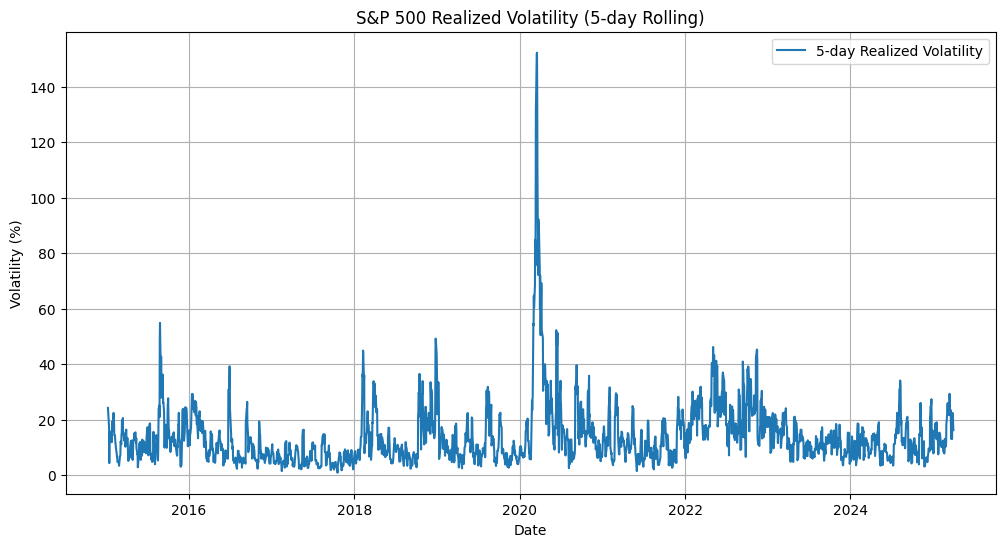

In [3]:
#Get the S&P 500 data from Yahoo Finance
data = yf.download('^GSPC', start='2015-01-01', end='2025-04-01', progress=False)
data = data.ffill()

# Use 'Close' price only
sp_500 = data['Close']

# Compute log returns in percent
log_returns = np.log(sp_500 / sp_500.shift(1)).dropna() * 100  # daily returns (%)

# Compute realized volatility (5-day rolling, annualized)
rolling_volatility_realized = log_returns.rolling(window=5).std() * np.sqrt(252)
rolling_volatility_realized = rolling_volatility_realized.dropna()

# Plot realized volatility
plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility_realized, label='5-day Realized Volatility')
plt.title('S&P 500 Realized Volatility (5-day Rolling)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.show()

## Forecasting Volatility Using a GARCH(1,1) Model

To model the conditional variance of asset returns, we use the GARCH(1,1) model — a cornerstone of financial econometrics. This model assumes that today's volatility depends on both yesterday's squared return (shock) and yesterday's conditional variance, making it well-suited to capture volatility clustering observed in financial markets.

We apply the GARCH(1,1) model to the S&P 500 index's daily log returns. The model is fitted using a rolling window approach, allowing us to generate dynamic, out-of-sample volatility forecasts that evolve with the market.

Forecasts are annualized and compared to realized volatility, which is computed using a rolling standard deviation over a 5-day horizon. This setup simulates a real-world forecasting environment and allows us to benchmark the GARCH model’s performance using RMSE, MAE, and MAPE.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3319.60
Distribution:                  Normal   AIC:                           6647.20
Method:            Maximum Likelihood   BIC:                           6670.62
                                        No. Observations:                 2575
Date:                Wed, Apr 02 2025   Df Residuals:                     2574
Time:                        15:16:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0770  1.477e-02      5.213  1.858e-07 [4.804e-0

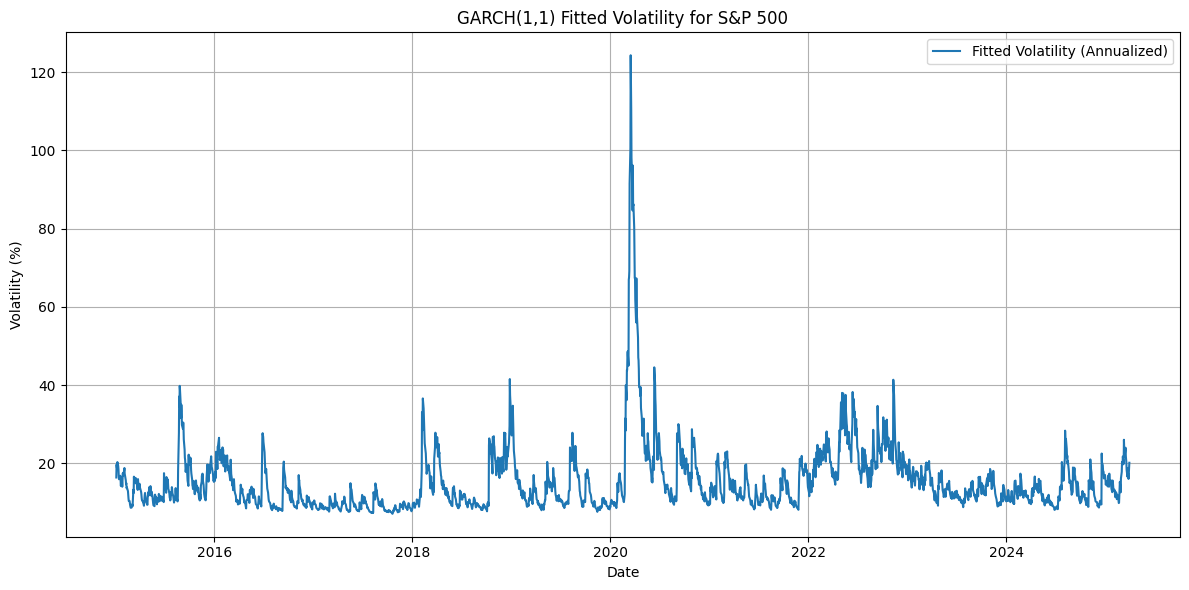

In [4]:
# Fit GARCH(1,1) in-sample
model = arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal')
model_fit = model.fit(disp='off')
print(model_fit.summary())

# Plot fitted conditional volatility (in-sample)
plt.figure(figsize=(12, 6))
plt.plot(model_fit.conditional_volatility * np.sqrt(252), label='Fitted Volatility (Annualized)')
plt.title('GARCH(1,1) Fitted Volatility for S&P 500')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Forecasting Out-of-Sample Volatility Using a GARCH Model

To simulate a realistic forecasting scenario, we implement a rolling window procedure. At each iteration, the GARCH(1,1) model is re-estimated using a fixed-size historical window, and a one-step-ahead volatility forecast is generated. This process mimics how a forecaster would update their model over time using only information available at the moment of prediction.

The GARCH-implied volatility forecasts are annualized and compared to the realized volatility computed from forward-looking 5-day return windows. This comparison allows us to assess how well the model anticipates future market variability based on past information.

This dynamic, out-of-sample evaluation offers a more robust picture of the model’s practical forecasting power compared to static in-sample fitting.

100%|██████████| 1574/1574 [00:08<00:00, 184.13it/s]


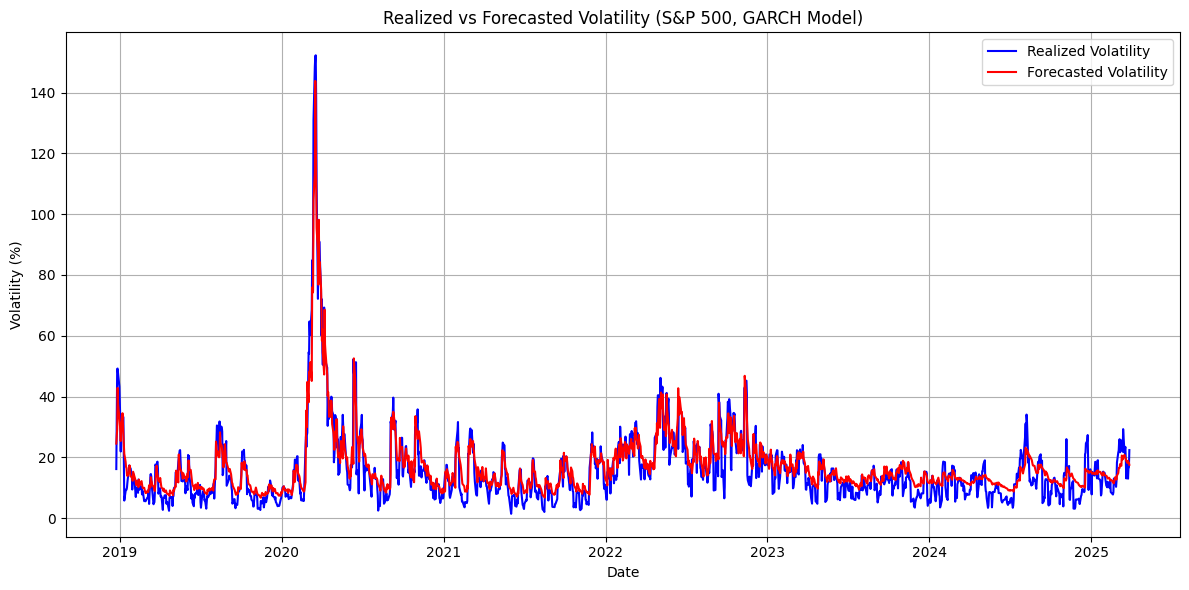

In [5]:
#Rolling forecast (out-of-sample)
window_size = 1000
num_forecasts = 1
rolling_predictions = []
forecast_dates = []

log_returns_series = log_returns.copy()

for i in tqdm(range(window_size, len(log_returns_series) - num_forecasts)):
    train_data = log_returns_series.iloc[i - window_size:i]

    try:
        model = arch_model(train_data, vol='Garch', p=1, q=1, dist='normal')
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=num_forecasts)
        avg_var = forecast.variance.values[-1, :num_forecasts].mean()
        vol_forecast = np.sqrt(avg_var) * np.sqrt(252)
        rolling_predictions.append(vol_forecast)

        forecast_date = log_returns_series.index[i + num_forecasts - 1]
        forecast_dates.append(forecast_date)

    except Exception as e:
        print(f"⚠️ Forecast failed at index {i}: {e}")
        continue

# Create DataFrame of forecasts
rolling_predictions_df = pd.DataFrame(
    rolling_predictions,
    index=forecast_dates,
    columns=["Forecasted Volatility"]
)

# Align realized volatility
realized_vol = rolling_volatility_realized.loc[rolling_predictions_df.index]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label="Realized Volatility", color="blue")
plt.plot(rolling_predictions_df, label="Forecasted Volatility", color="red")
plt.title("Realized vs Forecasted Volatility (S&P 500, GARCH Model)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Extract forecasted and actual volatilities
y_true = realized_vol.values
y_pred = rolling_predictions_df["Forecasted Volatility"].values

# Compute RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 4.98
MAE: 3.63
MAPE: 90.42%


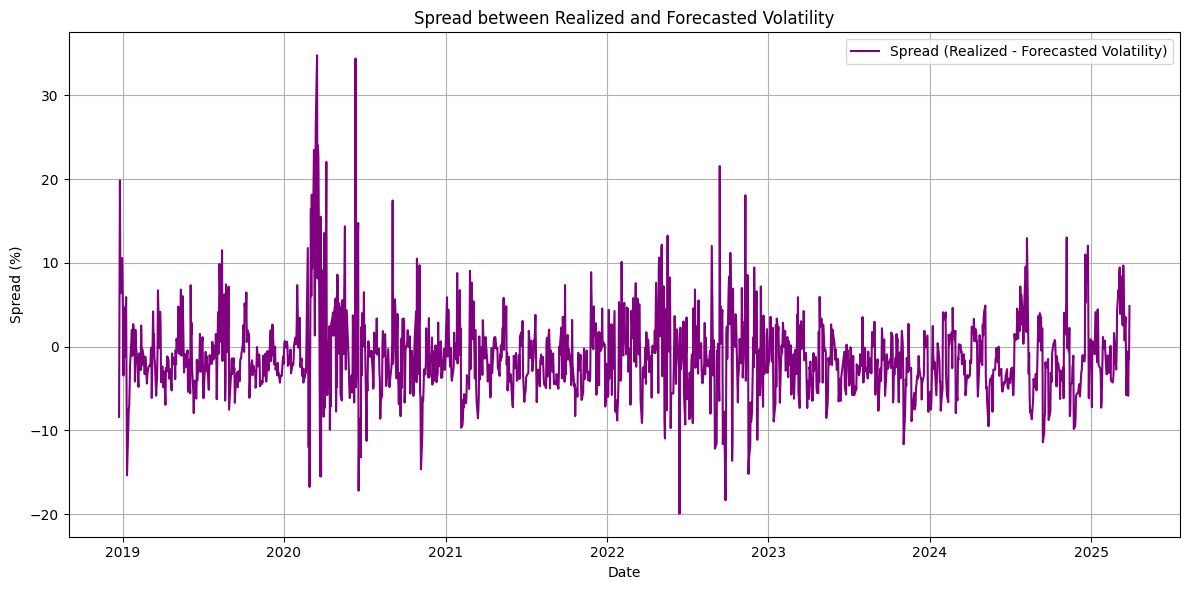

In [9]:
# Align columns for subtraction
spread = realized_vol.iloc[:, 0] - rolling_predictions_df.iloc[:, 0]

# Plot the spread
plt.figure(figsize=(12, 6))
plt.plot(spread, label="Spread (Realized - Forecasted Volatility)", color="purple")
plt.title("Spread between Realized and Forecasted Volatility")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Forecasting Volatility Using a HAR Model

The Heterogeneous Autoregressive (HAR) model, introduced by Corsi (2009), offers a simple yet powerful approach to modeling volatility by incorporating information from multiple time horizons. Unlike GARCH models, which focus on conditional variance dynamics, the HAR model directly models realized volatility using lagged daily, weekly, and monthly averages.

The intuition behind HAR lies in the **heterogeneity of market participants** — some react to daily news, others to weekly or monthly trends. By including multiple volatility components, the model captures long memory effects and persistence in volatility without requiring a complex nonlinear structure.

In this section, we use the HAR model to forecast the S&P 500’s realized volatility using lagged realized volatilities over 1-day, 5-day (weekly), and 22-day (monthly) windows. The model is estimated via linear regression and evaluated out-of-sample using rolling forecasts and standard performance metrics (RMSE, MAE, MAPE).

In [ ]:
# Function to create HAR (Heterogeneous Autoregressive) features
def create_har_features(rv_series): 
    # Create a DataFrame with the realized volatility series
    df = pd.DataFrame({'rv': rv_series})
    
    # Add lagged daily, weekly and monthly realized volatility 
    df['rv_d'] = df['rv'].shift(1)
    df['rv_w'] = df['rv'].rolling(window=5).mean().shift(1)
    df['rv_m'] = df['rv'].rolling(window=22).mean().shift(1)
    
    # Drop rows with NaN values caused by lagging
    df = df.dropna()
    
    #Return the DataFrame with HAR features
    return df

In [ ]:
def rolling_har_forecast(rv_series, window_size=500):
    
    """
    Perform rolling out-of-sample volatility forecasting using a HAR (Heterogeneous Autoregressive) model.
    
    The HAR model uses lagged daily, weekly, and monthly realized volatility as predictors in a linear regression.
    This function simulates a realistic forecasting setup where the model is re-estimated in a rolling fashion
    using a fixed-size training window, and a one-step-ahead forecast is generated at each step.
    
    Parameters:
    -----------
    rv_series : pd.Series
        Time series of realized volatility (e.g., computed from squared log returns or intraday data).
    window_size : int, optional (default=500)
        Number of past observations used to train the model at each rolling window step.
    
    Returns:
    --------
    pred_series : pd.Series
        One-step-ahead HAR forecasted volatility series, aligned with test indices.
    actual_series : pd.Series
        Actual realized volatility values corresponding to each forecast.
    """
    
    
    # Create HAR features (daily, weekly, and monthly lags)
    df = create_har_features(rv_series)
    
    # Initialize lists to store predictions, actual values, and indices
    predictions = []
    actuals = []
    index = []
    
    # Perform rolling window forecasting
    for i in range(window_size, len(df)):
        # Define the training data (window_size observations)
        train = df.iloc[i - window_size:i]
        
        # Define the test data (current observation)
        test = df.iloc[i]
        
        # Extract features (daily, weekly, monthly lags) and target (realized volatility)
        X_train = train[['rv_d', 'rv_w', 'rv_m']]
        y_train = train['rv']
        X_test = test[['rv_d', 'rv_w', 'rv_m']].values.reshape(1, -1)
        y_test = test['rv']
        
        # Fit a linear regression model on the training data
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict the realized volatility for the test data
        y_pred = model.predict(X_test)[0]
        
        # Append the prediction, actual value, and index to their respective lists
        predictions.append(y_pred)
        actuals.append(y_test)
        index.append(df.index[i])
    
    # Convert predictions and actuals to pandas Series with the corresponding indices
    pred_series = pd.Series(predictions, index=index)
    actual_series = pd.Series(actuals, index=index)
    
    # Return the predicted and actual realized volatility series
    return pred_series, actual_series

In [ ]:
# Run the forecast
har_forecast, har_actual = rolling_har_forecast(realized_vol, window_size=500)

# Compile Metrics
rmse_har = np.sqrt(mean_squared_error(har_actual, har_forecast))
mae_har = mean_absolute_error(har_actual, har_forecast)
mape_har = np.mean(np.abs((har_actual - har_forecast) / har_actual)) * 100

# Print results
print(f"HAR RMSE: {rmse_har:.2f}")
print(f"HAR MAE: {mae_har:.2f}")
print(f"HAR MAPE: {mape_har:.2f}%")

/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/vola

HAR RMSE: 3.86
HAR MAE: 2.57
HAR MAPE: 21.48%


/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/vola

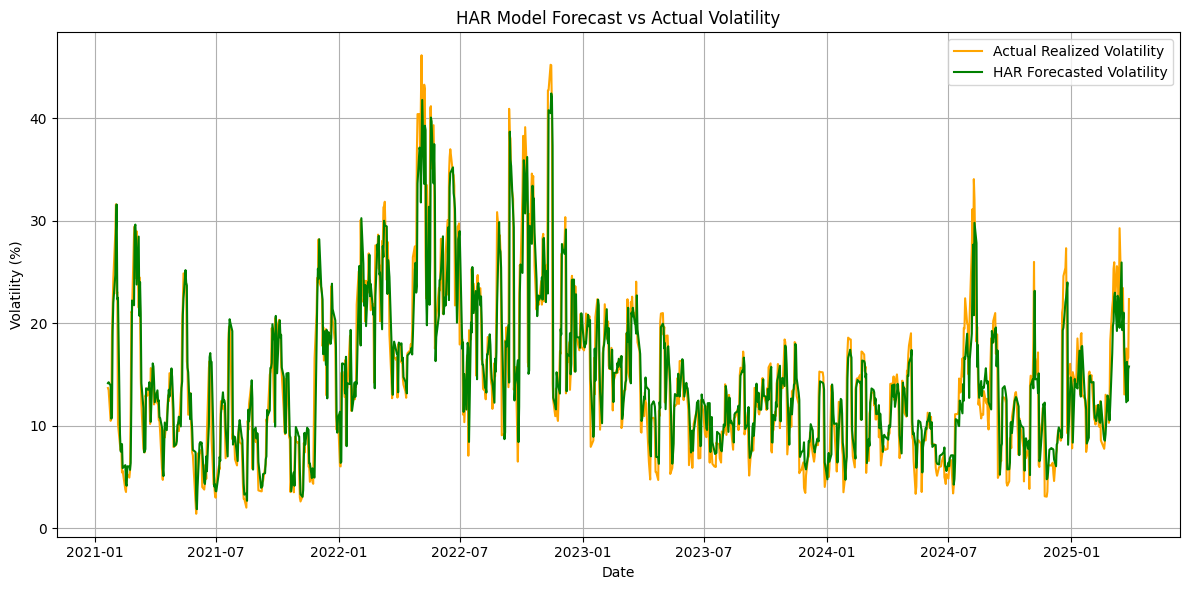

In [70]:
# Plot HAR forecast vs actual realized volatility

plt.figure(figsize=(12, 6))
plt.plot(har_actual, label='Actual Realized Volatility', color='orange')
plt.plot(har_forecast, label='HAR Forecasted Volatility', color='green')
plt.title('HAR Model Forecast vs Actual Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Machine Learning Models

In this section, we explore the use of machine learning algorithms to forecast volatility. Unlike traditional time series models that rely on predefined statistical structures, machine learning models can learn complex, nonlinear relationships directly from the data.

We begin by constructing lagged features from realized volatility and, in some cases, GARCH-implied volatility to serve as predictors. These features are then used to train various machine learning models, including:

- **Random Forest Regressor**: A tree-based ensemble method capable of capturing nonlinearities and feature interactions.
- **Decision Tree Regressor**: A simple yet interpretable model useful for establishing baseline performance within the machine learning context.
- **Deep Neural Networks (DNNs)**: Fully connected neural networks that can approximate complex functions and patterns in high-dimensional data.
- **LSTM Networks**: A class of recurrent neural networks well-suited for sequential data and temporal dependencies.

Each model is trained using a rolling forecast approach and evaluated using standard error metrics (RMSE, MAE, MAPE) to ensure comparability with the time series models. By comparing the performance across these models, we aim to understand the trade-offs between interpretability, accuracy, and model complexity.

## Forecasting Volatility Using Random Forest

The Random Forest Regressor is an ensemble learning method that combines multiple decision trees to produce more robust and accurate predictions. It works by training many trees on bootstrapped samples of the data and averaging their predictions, reducing the risk of overfitting and capturing complex interactions between features.

In this section, we use lagged realized volatility and, optionally, GARCH-implied volatility as input features to forecast future realized volatility. The model is trained using a rolling window approach to simulate out-of-sample forecasting conditions.

Random Forest is particularly well-suited for volatility forecasting because it can handle nonlinearity and collinearity in financial time series data without requiring strong parametric assumptions. We evaluate the model’s predictive accuracy using RMSE, MAE, and MAPE, and later assess its interpretability using SHAP values to understand feature importance.

In [ ]:
# Load the 5-day realized volatility series (annualized, in %) for a single asset (e.g., S&P 500)

# Convert the selected column into a 1D Series
realized_vol_series = rolling_volatility_realized.iloc[:, 0]

# Set the number of lagged features to use as model inputs
n_lags = 5

# Define a function to create a supervised learning dataset using lagged values of realized volatility
def create_lagged_features(series, n_lags=5):
    """
    Create a DataFrame of lagged features for time series forecasting.

    Parameters:
    -----------
    series : pd.Series
        The time series of realized volatility (target variable).
    n_lags : int
        Number of lagged observations to use as features.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame with lagged features (y_lag1 to y_lagN) and the target variable 'y'.
    """
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'y_lag{i}'] = df['y'].shift(i)  # Create lagged features
    return df.dropna()  # Drop initial rows with NaN due to shifting

# Generate the lagged feature set for the Random Forest model
df_rf = create_lagged_features(realized_vol_series, n_lags=n_lags)

In [ ]:
# Set the rolling window size for training (e.g., use the last 500 days of data for each forecast)
window_size = 500

# Initialize lists to store predictions, actual values, and forecast dates
predictions = []
actuals = []
forecast_index = []

# Rolling forecast loop: walk forward day by day, re-train the model, and generate a 1-step-ahead prediction
for i in tqdm(range(window_size, len(df_rf))):
    # Define training data: the past `window_size` days
    train = df_rf.iloc[i - window_size:i]
    
    # Define test data: the current day (1-step-ahead forecast)
    test = df_rf.iloc[i]

    # Split features and target variable
    X_train = train.drop(columns='y')
    y_train = train['y']
    X_test = test.drop('y').values.reshape(1, -1)  # Reshape to keep 2D input for sklearn

    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make prediction for the next time step
    pred = model.predict(X_test)[0]
    actual = test['y']

    # Store results
    predictions.append(pred)
    actuals.append(actual)
    forecast_index.append(df_rf.index[i])

  0%|          | 0/2066 [00:00<?, ?it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 1/2066 [00:00<04:08,  8.32it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 2/2066 [00:00<03:45,  9.15it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ran

In [ ]:
# Convert actual and predicted values to NumPy arrays for metric computation
y_true = np.array(actuals)
y_pred = np.array(predictions)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print out model evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 4.95
MAE: 2.96
MAPE: 25.55%


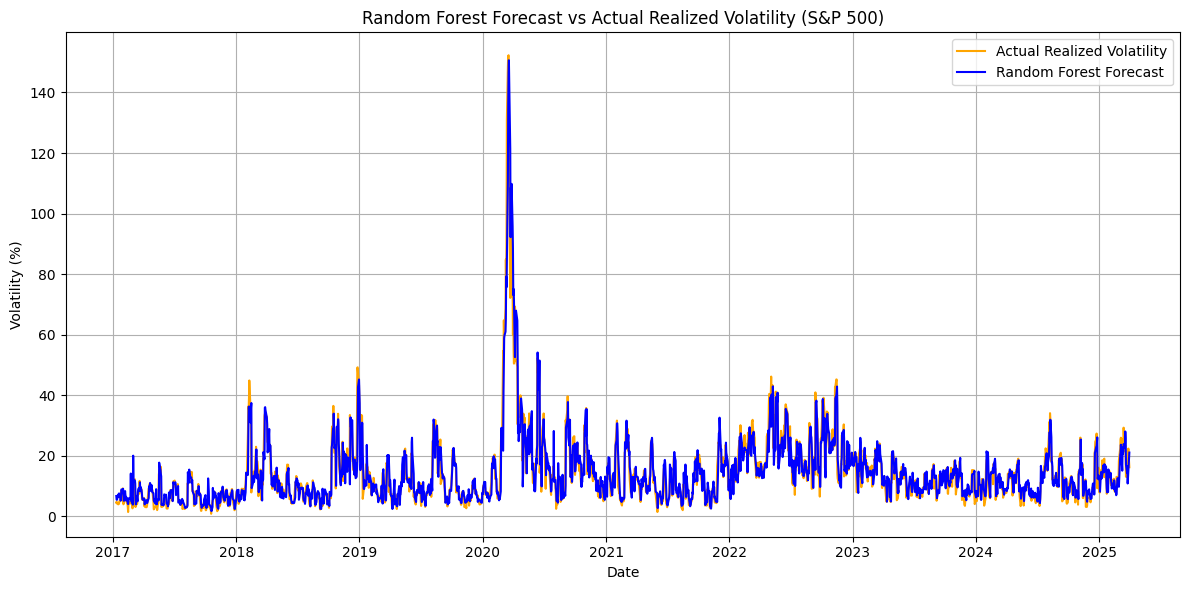

In [ ]:
# Convert predictions and actuals into pandas Series for plotting, aligned by date
forecast_series = pd.Series(y_pred, index=forecast_index)
actual_series = pd.Series(y_true, index=forecast_index)

# Plot the predicted vs actual realized volatility
plt.figure(figsize=(12, 6))
plt.plot(actual_series, label='Actual Realized Volatility', color='orange')
plt.plot(forecast_series, label='Random Forest Forecast', color='blue')
plt.title("Random Forest Forecast vs Actual Realized Volatility (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

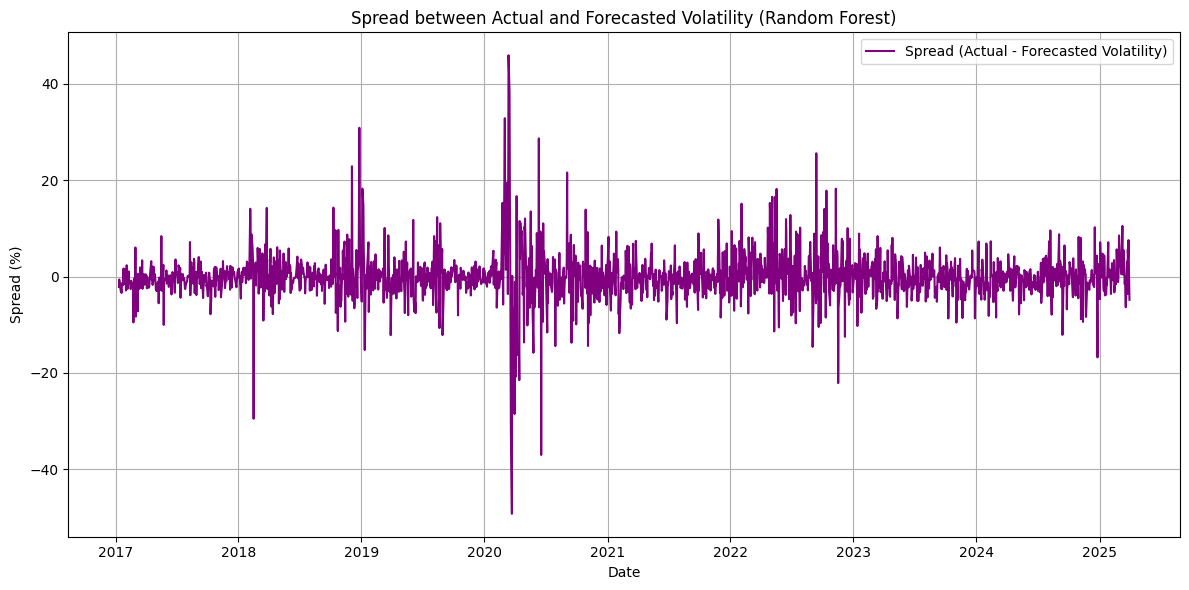

In [ ]:
#Compute the spread
spread_rf = actual_series - forecast_series

# Plot the spread between actual and forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(spread_rf, label="Spread (Actual - Forecasted Volatility)", color="purple")
plt.title("Spread between Actual and Forecasted Volatility (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Hybrid Approach – Random Forest + GARCH Model

To enhance the forecasting accuracy of the Random Forest model, we introduce a hybrid approach that incorporates GARCH model forecasts as an additional input feature. While Random Forests are powerful in capturing nonlinear interactions, they are agnostic to time-series-specific structures such as volatility clustering. The GARCH(1,1) model, on the other hand, is specifically designed to capture conditional heteroskedasticity in financial data.

By combining the two, we aim to preserve the statistical structure captured by GARCH while allowing the Random Forest to model more complex, nonlinear patterns that the GARCH model alone cannot.

In this hybrid setup:
- Lagged realized volatilities (e.g., from the past 5 days) are used as standard features.
- The 1-day ahead GARCH-implied volatility forecast is added as an additional feature at each step in the rolling window.

We evaluate this hybrid model using RMSE, MAE, and MAPE, and compare it to the standalone models to assess whether the combination yields superior predictive performance.

In [ ]:
#Create a DataFrame for the GARCH forecast
garch_forecast_series = pd.Series(rolling_predictions, index=forecast_dates)
garch_forecast_series.name = 'garch_forecast'

In [ ]:
# Function to create hybrid features combining lagged realized volatility and lagged GARCH forecasts
def create_hybrid_features(vol_series, garch_series, n_lags=5):
    """
    Create a DataFrame of lagged features for hybrid volatility forecasting models.

    Combines lagged realized volatility values and corresponding lagged GARCH(1,1) forecast values
    to be used as input features for machine learning models such as Random Forest.

    Parameters:
    -----------
    vol_series : pd.Series
        Time series of realized volatility (target variable).
    garch_series : pd.Series
        Time series of GARCH-implied volatility forecasts.
    n_lags : int
        Number of lagged observations to include for both volatility and GARCH.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame containing:
        - Target variable 'y' (realized volatility)
        - Lagged realized volatility features: y_lag1 to y_lagN
        - Lagged GARCH forecast features: garch_lag1 to garch_lagN
    """
    df = pd.DataFrame({'y': vol_series})
    
    for i in range(1, n_lags + 1):
        df[f'y_lag{i}'] = df['y'].shift(i)
        df[f'garch_lag{i}'] = garch_series.shift(i)

    return df.dropna()

In [ ]:
# Ensure both are Series and aligned
realized_vol_series = realized_vol.squeeze()  
garch_forecast_series = garch_forecast_series.squeeze()

# Align both by index (inner join)
aligned_realized_vol, aligned_garch_forecast = realized_vol_series.align(
    garch_forecast_series, join='inner')

# Proceed to build features
df_hybrid = create_hybrid_features(aligned_realized_vol, aligned_garch_forecast, n_lags=5)

In [ ]:
# Estimate the hybrid model using Random Forest with HAR + GARCH features

# Set rolling window size for training
window_size = 500

# Initialize lists to store predictions, actual values, and forecast dates
hybrid_preds = []
hybrid_actuals = []
hybrid_index = []

# Rolling forecast loop
# For each point in time, use the past `window_size` observations to train the model 
# and predict the next day's realized volatility
for i in tqdm(range(window_size, len(df_hybrid))):
    # Define the training and test set for this iteration
    train = df_hybrid.iloc[i - window_size:i]
    test = df_hybrid.iloc[i]

    # Separate features (lagged realized + GARCH) and target (realized volatility)
    X_train = train.drop(columns='y')
    y_train = train['y']
    X_test = test.drop('y').values.reshape(1, -1)  # Ensure 2D input for sklearn

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make prediction and store results
    pred = model.predict(X_test)[0]
    actual = test['y']

    hybrid_preds.append(pred)
    hybrid_actuals.append(actual)
    hybrid_index.append(df_hybrid.index[i])

  0%|          | 0/1069 [00:00<?, ?it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 1/1069 [00:00<03:13,  5.52it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
  0%|          | 2/1069 [00:00<03:03,  5.81it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ran

In [ ]:
# Convert actual and predicted values to NumPy arrays
y_true = np.array(hybrid_actuals)
y_pred = np.array(hybrid_preds)

# Compute the metrics 
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print out the evaluation metrics for the hybrid model
print(f"HYBRID RMSE: {rmse:.2f}")
print(f"HYBRID MAE: {mae:.2f}")
print(f"HYBRID MAPE: {mape:.2f}%")

HYBRID RMSE: 3.84
HYBRID MAE: 2.67
HYBRID MAPE: 22.54%


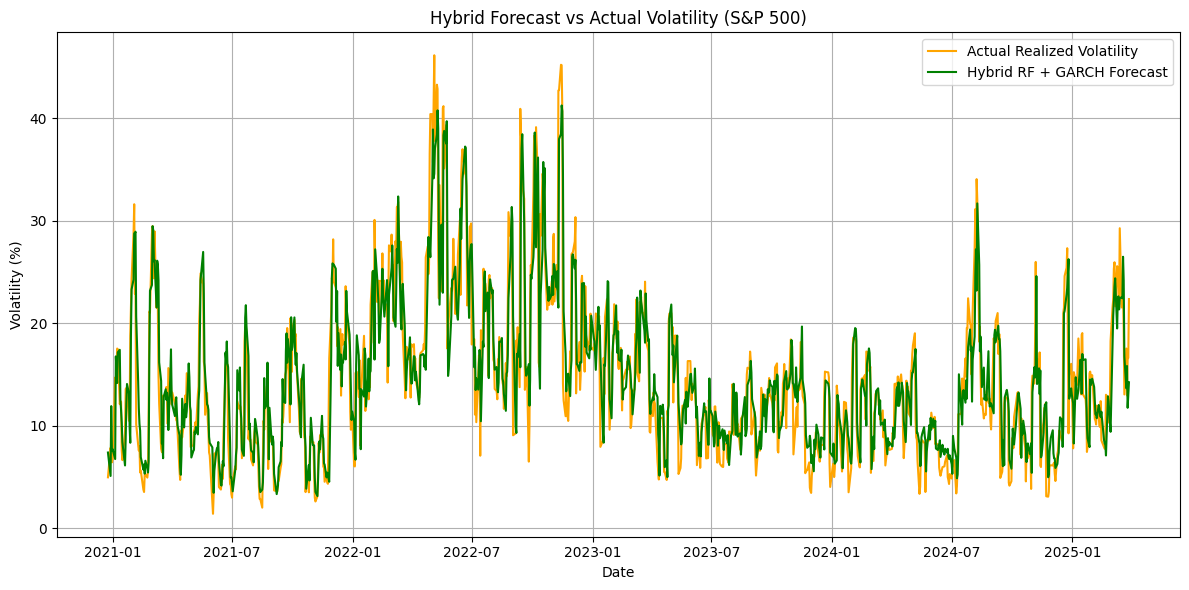

In [ ]:
# Convert predictions and actuals into pandas Series for plotting, aligned by date
hybrid_series = pd.Series(y_pred, index=hybrid_index)
actual_series = pd.Series(y_true, index=hybrid_index)

# Plot the predicted vs actual realized volatility for the hybrid model
plt.figure(figsize=(12, 6))
plt.plot(actual_series, label='Actual Realized Volatility', color='orange')
plt.plot(hybrid_series, label='Hybrid RF + GARCH Forecast', color='green')
plt.title("Hybrid Forecast vs Actual Volatility (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Decision Tree Regressor for Volatility Forecasting

The Decision Tree Regressor is a simple yet interpretable machine learning model that partitions the feature space into distinct regions by learning a hierarchy of decision rules. Although it lacks the ensemble power of methods like Random Forests, it provides valuable insights into feature importance and serves as a strong baseline for model comparison.

In this section, we use a rolling forecast framework to train and evaluate a Decision Tree model for predicting realized volatility. The input features consist of lagged values of realized volatility, and optionally, GARCH-implied volatility (in the hybrid setup). 

We evaluate the model's performance using standard error metrics — RMSE, MAE, and MAPE — and compare it with more complex models to assess the trade-offs between interpretability and predictive accuracy.

In [ ]:
# Function to create lagged features for a Decision Tree Regressor using both realized and GARCH volatility

def create_tree_features(realized, garch, n_lags=5):
    """
    Constructs a feature matrix for volatility forecasting models using lagged realized volatility
    and GARCH-implied volatility forecasts.

    Parameters:
    -----------
    realized : pd.Series
        Time series of realized volatility (target variable).
    garch : pd.Series
        Time series of GARCH(1,1) forecasted volatility.
    n_lags : int
        Number of lagged observations to include as features.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame containing:
        - Target variable 'y' (realized volatility)
        - Lagged realized volatility features: vol_lag1 to vol_lagN
        - Lagged GARCH forecast features: garch_lag1 to garch_lagN
    """
    df = pd.DataFrame({'y': realized})
    for i in range(1, n_lags + 1):
        df[f'vol_lag{i}'] = realized.shift(i)
        df[f'garch_lag{i}'] = garch.shift(i)
    return df.dropna()

# Create the feature matrix for training the Decision Tree Regressor
df_tree = create_tree_features(realized_vol.squeeze(), garch_forecast_series, n_lags=5)

In [ ]:
# Split the data into training and testing sets using an 80/20 split

# Determine the number of training samples (80% of the total data)
train_size = int(len(df_tree) * 0.8)

# Slice the DataFrame into training and testing sets based on chronological order
train = df_tree.iloc[:train_size]
test = df_tree.iloc[train_size:]

# Separate features and target variable for training and testing sets
X_train = train.drop(columns='y')
y_train = train['y']
X_test = test.drop(columns='y')
y_test = test['y']

In [ ]:
# Initialize the model with a controlled maximum depth to avoid overfitting
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)

# Train the model on the training set
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=42)

In [ ]:
# Generate predictions on the test set
y_pred = tree_model.predict(X_test)

# Compute the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print evaluation results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 3.46
MAE: 2.45
MAPE: 25.24%


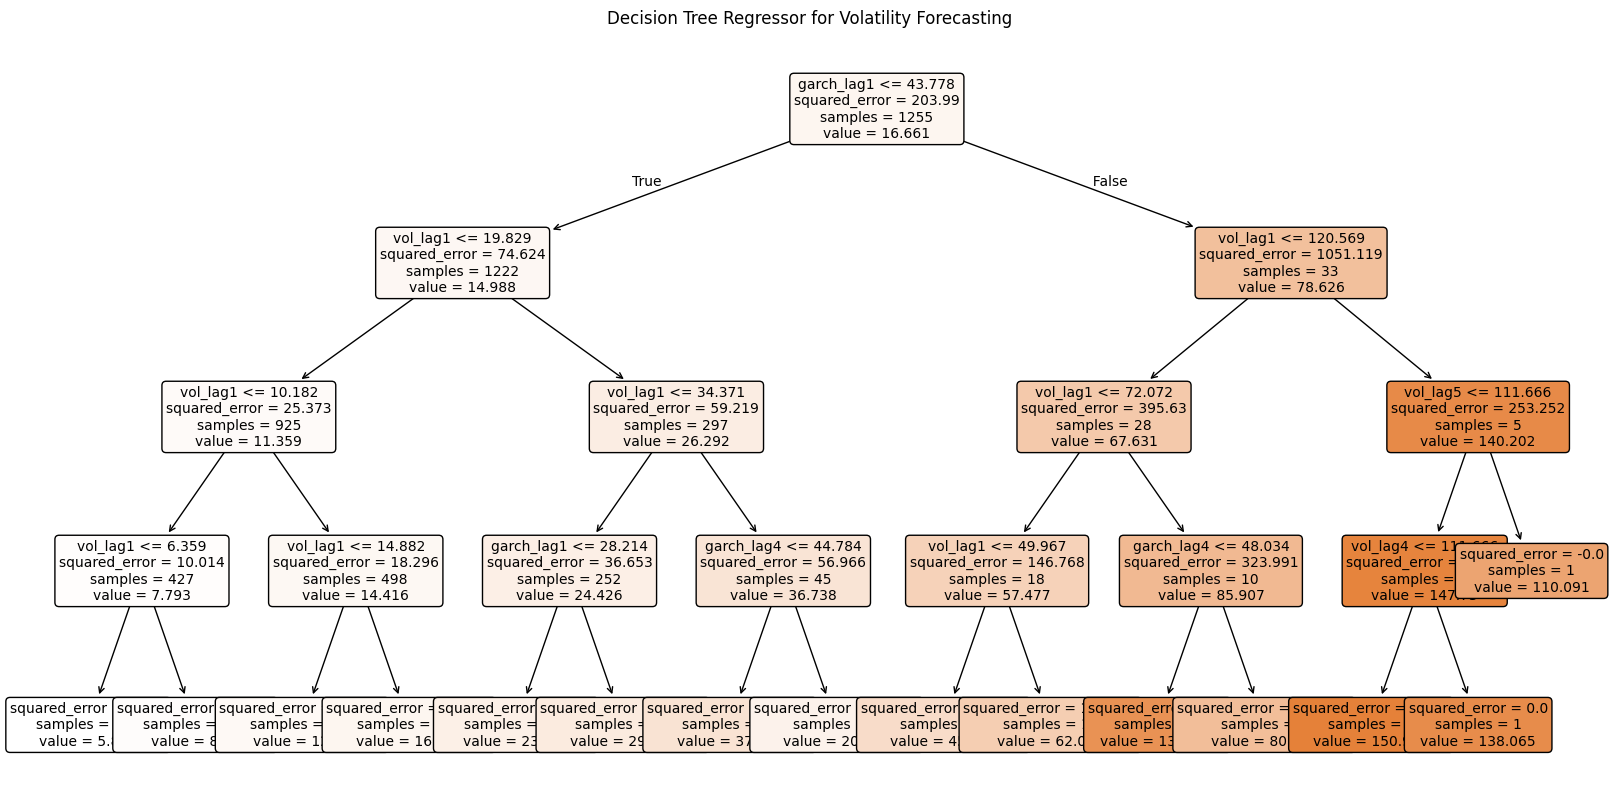

In [ ]:
# Plot the trained Decision Tree to visualize its structure and decision rules

plt.figure(figsize=(20, 10))  
plot_tree(
    tree_model,
    feature_names=X_train.columns,  
    filled=True,                    
    rounded=True,                   
    fontsize=10                     
)

plt.title("Decision Tree Regressor for Volatility Forecasting")
plt.show()

In [ ]:
# Rolling Forecast with Decision Tree

#Initialize lists for predictions and actual values
window_size = 500
tree_preds = []
tree_actuals = []
tree_index = []

# Loop through the data for rolling predictions
for i in tqdm(range(window_size, len(df_tree))):
    train = df_tree.iloc[i - window_size:i]
    test = df_tree.iloc[i]

    # Split the data into features and target
    X_train = train.drop(columns='y')
    y_train = train['y']
    X_test = test.drop('y').values.reshape(1, -1)

    # Fit the Decision Tree model   
    model = DecisionTreeRegressor(max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    pred = model.predict(X_test)[0]
    actual = test['y']

    # Append predictions and actual values to lists
    tree_preds.append(pred)
    tree_actuals.append(actual)
    tree_index.append(df_tree.index[i])
    

# Create a DataFrame for the Decision Tree predictions
y_true = np.array(tree_actuals)
y_pred = np.array(tree_preds)


# Compute the metrics for the Decision Tree model
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the evaluation metrics
print(f"Decision Tree RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

  0%|          | 0/1069 [00:00<?, ?it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTH

Decision Tree RMSE: 4.33
MAE: 2.96
MAPE: 24.76%


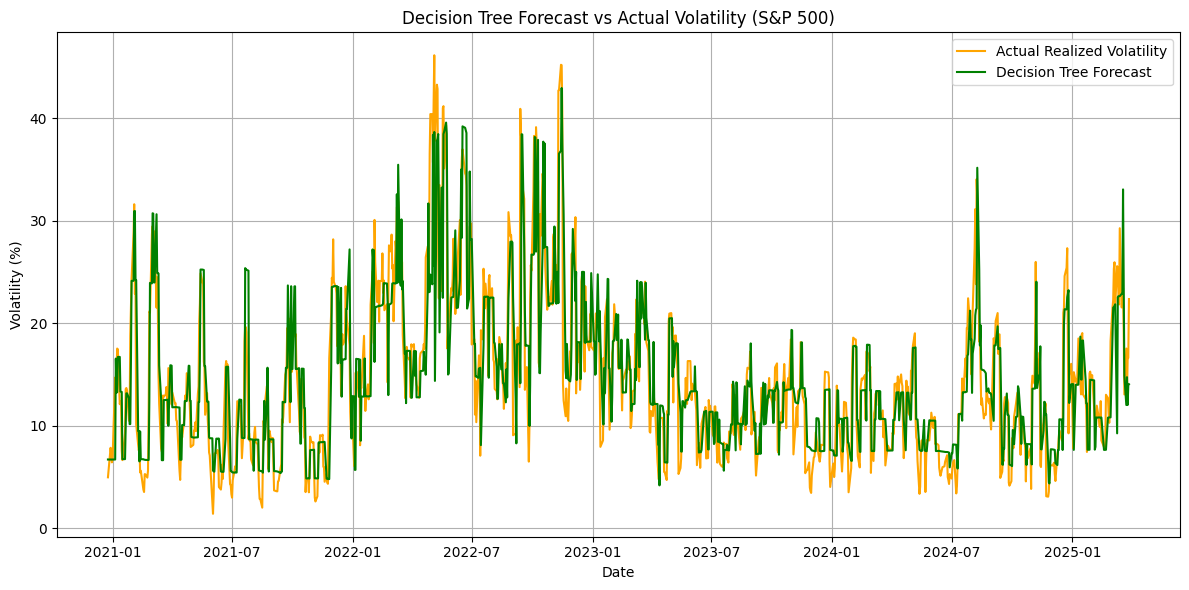

In [ ]:
# Convert actual and predicted values to pandas Series for plotting
tree_series = pd.Series(y_pred, index=tree_index)
actual_series = pd.Series(y_true, index=tree_index)

# Plot the Decision Tree forecast vs actual realized volatility
plt.figure(figsize=(12, 6))
plt.plot(actual_series, label='Actual Realized Volatility', color='orange')
plt.plot(tree_series, label='Decision Tree Forecast', color='green')
plt.title("Decision Tree Forecast vs Actual Volatility (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

_______

## Deep Neural Networks – Forecasting Volatility

Deep Neural Networks (DNNs) offer a flexible, non-parametric approach to modeling complex and nonlinear relationships in financial time series data. Unlike traditional econometric models, DNNs do not require strong assumptions about the underlying data-generating process. Instead, they can **learn intricate interactions across features**, including lagged realized volatility and GARCH-implied volatility, directly from the data.

In this section, we train a fully connected feedforward neural network to forecast future realized volatility using a supervised learning setup with lag-based input features. The model is evaluated in an out-of-sample setting and benchmarked against traditional and tree-based models.

Key motivations:
- Model **nonlinear dynamics** that linear models may miss
- Capture **interactions across multiple time horizons** (lags) and indicators (e.g., GARCH)
- Establish a neural baseline for later extensions using more sophisticated temporal models such as **LSTMs**

In [ ]:
# Create input features for a Neural Network using lagged realized volatility and GARCH forecasts

def create_nn_features(realized_vol, garch_forecast_series, n_lags=5):
    """
    Generates lagged features for training a Deep Neural Network to forecast realized volatility.
    
    Combines:
    - Lagged realized volatility values (vol_lag1 to vol_lagN)
    - Lagged GARCH(1,1) forecast values (garch_lag1 to garch_lagN)
    
    Parameters:
    -----------
    realized_vol : pd.Series
        Time series of realized (target) volatility.
    garch_forecast_series : pd.Series
        Time series of GARCH-implied forecasted volatility.
    n_lags : int
        Number of lagged features to include for both realized and GARCH volatilities.
        
    Returns:
    --------
    df : pd.DataFrame
        Feature matrix with lagged predictors and target variable 'y'.
    """
    df = pd.DataFrame({'y': realized_vol})
    
    for i in range(1, n_lags + 1):
        df[f'vol_lag{i}'] = realized_vol.shift(i)
        df[f'garch_lag{i}'] = garch_forecast_series.shift(i)
        
    return df.dropna()

In [ ]:
def rolling_nn_forecast(df, window_size=500, epochs=50, batch_size=32, verbose=0):
    """
    Perform rolling out-of-sample forecasting using a Deep Neural Network (DNN).
    
    At each step, the DNN is trained on a rolling window of the most recent `window_size` observations
    and used to generate a one-step-ahead forecast for realized volatility.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the target variable 'y' and lagged feature columns.
    window_size : int, default=500
        Number of observations used to train the model at each step.
    epochs : int, default=50
        Number of training epochs for each DNN fit.
    batch_size : int, default=32
        Batch size used during model training.
    verbose : int, default=0
        Verbosity level for Keras training and prediction.

    Returns:
    --------
    predictions : pd.Series
        Forecasted values for realized volatility.
    actuals : pd.Series
        Actual realized volatility values corresponding to each prediction.
    """
    predictions, actuals, indices = [], [], []

    scaler = StandardScaler()  # Normalize input features to improve training stability

    for i in tqdm(range(window_size, len(df))):
        # Create rolling training and testing sets
        train = df.iloc[i - window_size:i]
        test = df.iloc[i]

        X_train = train.drop(columns='y')
        y_train = train['y']
        X_test = test.drop('y').values.reshape(1, -1)

        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Define the DNN architecture
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))  # Output layer for regression

        # Compile and train the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

        # Make prediction
        y_pred = model.predict(X_test_scaled, verbose=0)[0][0]

        # Store forecast and actual
        predictions.append(y_pred)
        actuals.append(test['y'])
        indices.append(df.index[i])

    return pd.Series(predictions, index=indices), pd.Series(actuals, index=indices)

In [ ]:
def evaluate_forecast(y_true, y_pred):
    """
    Evaluate the performance of a volatility forecasting model.

    Computes standard error metrics to assess how well the predicted values
    align with the actual (realized) volatility.

    Parameters:
    -----------
    y_true : array-like or pd.Series
        Actual values of realized volatility.
    y_pred : array-like or pd.Series
        Predicted values of realized volatility.

    Returns:
    --------
    rmse : float
        Root Mean Squared Error.
    mae : float
        Mean Absolute Error.
    mape : float
        Mean Absolute Percentage Error (as a percentage).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Penalizes large errors
    mae = mean_absolute_error(y_true, y_pred)           # Average absolute error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Relative error (%)
    return rmse, mae, mape

In [ ]:
# Apply squeeze to ensure both are Series
realized_vol = realized_vol.squeeze()

# Align both
realized_vol, garch_forecast_series = realized_vol.align(garch_forecast_series, join='inner')

# Run the function to create features
df_nn = create_nn_features(realized_vol, garch_forecast_series, n_lags=5)
y_pred_nn, y_true_nn = rolling_nn_forecast(df_nn, window_size=500, epochs=30)

# Evaluate the forecast
rmse, mae, mape = evaluate_forecast(y_true_nn, y_pred_nn)



  0%|          | 0/1069 [00:00<?, ?it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  0%|          | 1/1069 [00:00<15:48,  1.13it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/util

  0%|          | 5/1069 [00:04<14:34,  1.22it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1%|          | 6/1069 [00:05<14:26,  1.23it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  1%|          | 7/1069 [00:05<14:17,  1.24it/s]/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/skle

📊 DNN RMSE: 3.71
📊 MAE: 2.61
📊 MAPE: 22.98%


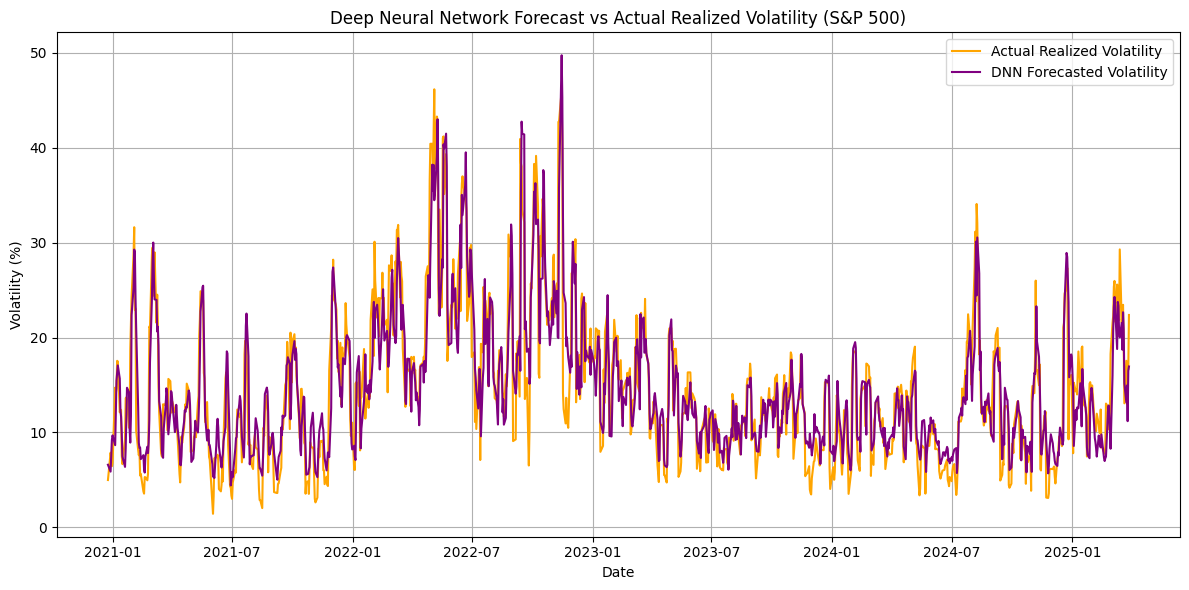

In [53]:
# Convert predictions and true values to Series 
forecast_series = pd.Series(y_pred_nn, index=y_true_nn.index)
actual_series = y_true_nn  

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_series, label='Actual Realized Volatility', color='orange')
plt.plot(forecast_series, label='DNN Forecasted Volatility', color='purple')
plt.title('Deep Neural Network Forecast vs Actual Realized Volatility (S&P 500)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Long Short-Term Memory (LSTM) Model for Volatility Forecasting

LSTM (Long Short-Term Memory) networks are a specialized form of Recurrent Neural Networks (RNNs) designed to handle sequential data and learn long-term dependencies. Unlike feedforward networks, LSTMs incorporate memory cells that allow them to retain information across time steps, making them particularly well-suited for time series forecasting tasks like financial volatility.

In this section, we apply an LSTM model to forecast realized volatility, using a supervised learning setup that includes lagged realized volatility and GARCH-implied volatility as input features. The LSTM is trained using a rolling window approach to simulate a real-world forecasting scenario, where the model is updated as new data becomes available.

### Why LSTM?
- Captures **temporal dynamics** that standard DNNs and tree models may overlook
- Naturally suited to **sequential financial data** with memory-like behavior (volatility persistence)
- Lays the groundwork for **hybrid models** that blend structured features (e.g., HAR) with deep sequential learning

We benchmark the LSTM model against traditional, machine learning, and hybrid approaches to evaluate its predictive accuracy and robustness.

In [ ]:
def create_lstm_sequences(realized_vol, garch_forecast, n_lags=5):
    """
    Prepare input sequences for LSTM-based volatility forecasting.

    This function constructs lagged sequences of realized volatility and GARCH-implied forecasts
    to train an LSTM model. Each sequence represents a sliding window of time-dependent features.

    Parameters:
    -----------
    realized_vol : pd.Series
        Time series of realized volatility (target variable).
    garch_forecast : pd.Series
        Time series of GARCH(1,1) forecasted volatility.
    n_lags : int, default=5
        Number of time steps (lags) to include in each sequence.

    Returns:
    --------
    X_lstm : np.ndarray
        3D array of shape (samples, timesteps, features) for LSTM input.
    y_lstm : np.ndarray
        1D array of corresponding target realized volatility values.
    index : pd.Index
        Index aligned with y_lstm, used for plotting or evaluation.
    """
    # Initialize DataFrame with the target variable
    df = pd.DataFrame({'y': realized_vol})
    
    # Add lagged features for both realized volatility and GARCH forecasts
    for i in range(1, n_lags + 1):
        df[f'y_lag{i}'] = realized_vol.shift(i)
        df[f'garch_lag{i}'] = garch_forecast.shift(i)
    
    # Drop rows with NaN values due to lagging
    df = df.dropna()

    # Extract feature matrix (X) and target array (y)
    X = df.drop(columns='y').values
    y = df['y'].values

    # Create sequences for LSTM: shape (samples, timesteps, features)
    samples = []
    for i in range(n_lags, len(X)):
        sample = X[i - n_lags:i]
        samples.append(sample)

    # Convert to NumPy arrays
    X_lstm = np.array(samples)
    y_lstm = y[n_lags:]  # Align targets with the start of each sequence

    return X_lstm, y_lstm, df.index[n_lags:]

In [63]:
# Align inputs
realized_vol = realized_vol.squeeze()
realized_vol, garch_forecast_series = realized_vol.align(garch_forecast_series, join='inner')

# Create input/output
X_lstm, y_lstm, dates = create_lstm_sequences(realized_vol, garch_forecast_series, n_lags=5)

# Scale features
scaler = StandardScaler()
X_reshaped = X_lstm.reshape(X_lstm.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped).reshape(X_lstm.shape)

# Train/test split
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]
test_dates = dates[train_size:]

In [ ]:
# Define the LSTM model
model = Sequential()

# Add an LSTM layer with 64 units, input shape matching the training data, and no return sequences
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add a dense layer with 1 unit for the output
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model on the training data with 50 epochs and a batch size of 32
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 517.8796   
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 335.0222
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 237.8682
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165.9872
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146.4707
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148.5575
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.6819
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166.0787
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158.4442
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.7141
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150.1752
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115.1791
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.1295
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.0723
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126.87

In [ ]:
# Generate predictions using the trained LSTM model
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics: RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)          # Mean Absolute Error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics for the LSTM Hybrid model
print(f"LSTM Hybrid RMSE: {rmse:.2f}")
print(f"LSTM Hybrid MAE: {mae:.2f}")
print(f"LSTM Hybrid MAPE: {mape:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Hybrid RMSE: 4.88
LSTM Hybrid MAE: 3.60
LSTM Hybrid MAPE: 35.58%


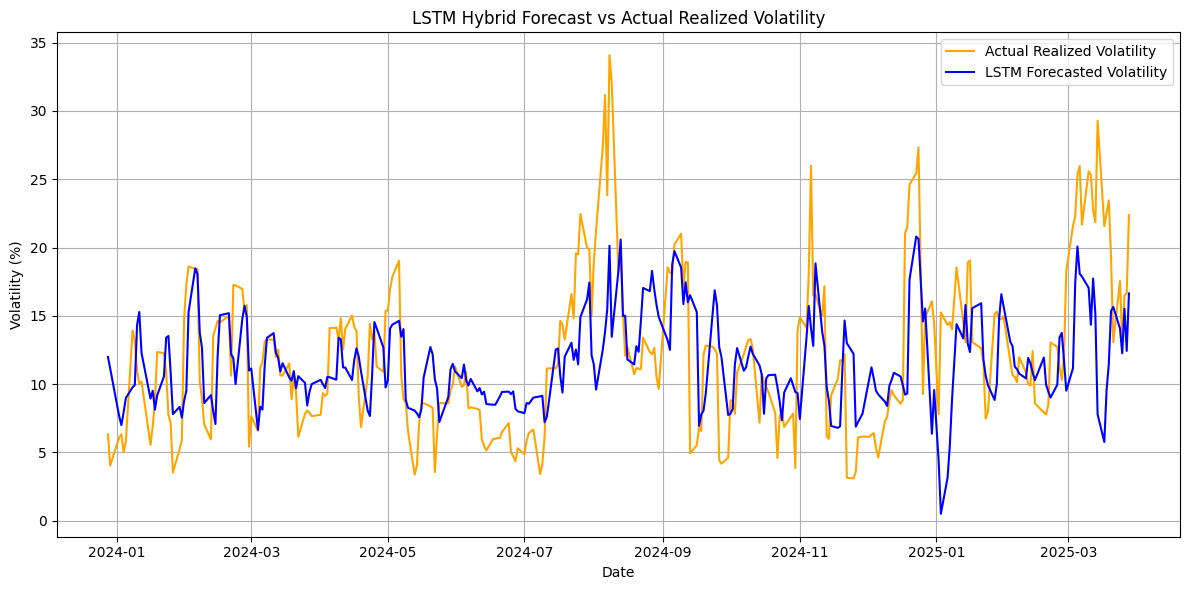

In [ ]:
# Plot the LSTM forecast vs actual realized volatility

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual Realized Volatility', color='orange')
plt.plot(test_dates, y_pred, label='LSTM Forecasted Volatility', color='blue')
plt.title('LSTM Hybrid Forecast vs Actual Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Comparison

In this final section, we bring together all the models developed throughout the project to compare their performance in forecasting realized volatility. Each model was evaluated using consistent metrics — RMSE, MAE, and MAPE — on a comparable dataset, ensuring a fair assessment of predictive accuracy.

The models include:

- **Traditional time series models**: GARCH(1,1), HAR
- **Machine learning models**: Random Forest, Decision Tree, Deep Neural Networks
- **Hybrid models**: RF + GARCH, HAR + DNN, LSTM + GARCH
- **Sequential deep learning**: LSTM

These models vary in complexity, interpretability, and ability to capture linear vs nonlinear patterns. By ranking them based on RMSE (the primary error metric), we can assess which approaches generalize best and which trade-offs are worth making between performance and model complexity.

We also include:
- **Visual plots** comparing predicted vs actual volatility
- **SHAP and ALE explainability** for interpreting ML models
- **Discussion** on when hybrid or neural models are most appropriate for volatility forecasting

The goal is not only to identify the "best" model, but also to highlight the value of combining domain-driven time series structures with flexible machine learning techniques.

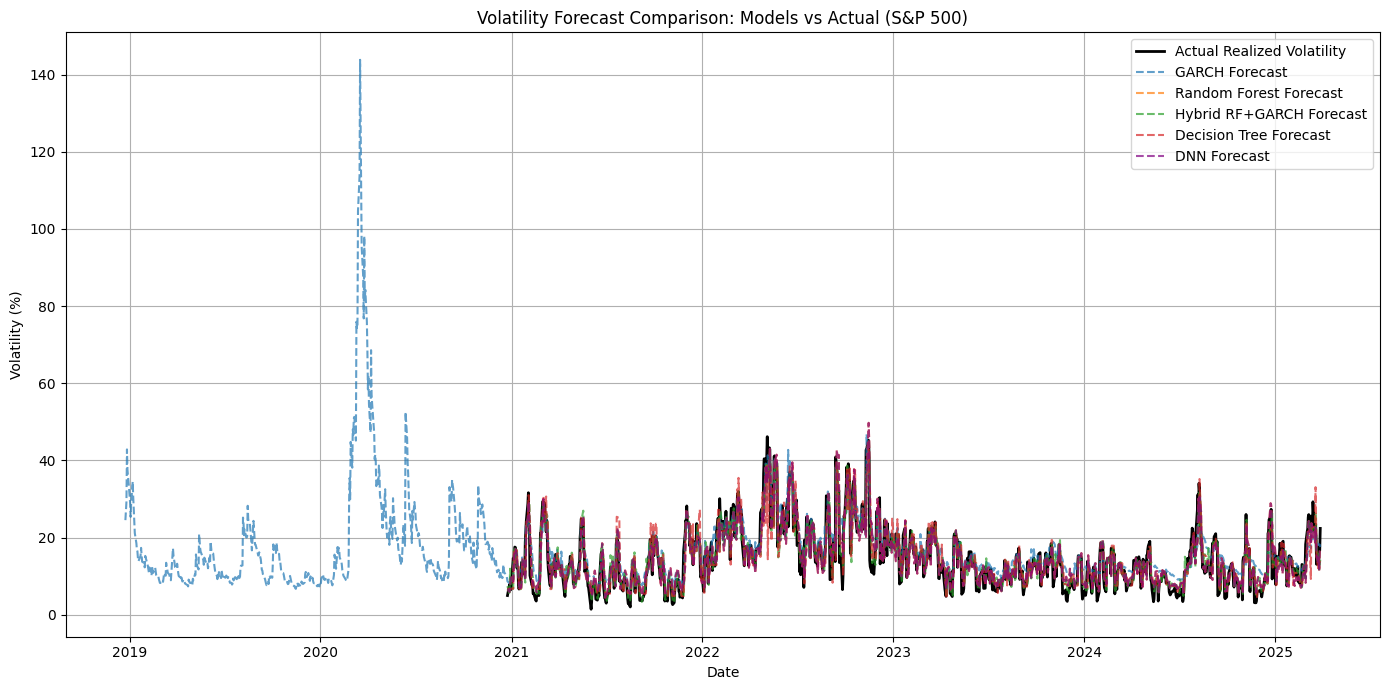

In [ ]:
# Plot the actual and forecasted volatility series from multiple models

plt.figure(figsize=(14, 7))

# Plot actual realized volatility
plt.plot(actual_series, label='Actual Realized Volatility', color='black', linewidth=2)

# Plot forecasted volatility from various models
plt.plot(garch_forecast_series, label='GARCH Forecast', linestyle='--', alpha=0.7)
plt.plot(rf_series, label='Random Forest Forecast', linestyle='--', alpha=0.7)
plt.plot(hybrid_series, label='Hybrid RF + GARCH Forecast', linestyle='--', alpha=0.7)
plt.plot(tree_series, label='Decision Tree Forecast', linestyle='--', alpha=0.7)
plt.plot(dnn_series, label='DNN Forecast', linestyle='--', alpha=0.7, color='purple')

# Title and axis labels
plt.title('Volatility Forecast Comparison: Models vs Actual (S&P 500)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')

# Add legend and grid
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

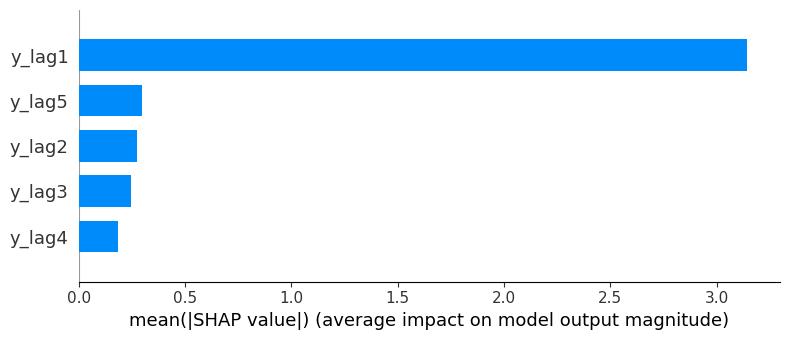

In [ ]:
# SHAP Analysis for Random Forest Regressor

# Train a final Random Forest model using the most recent window of data
final_rf_df = df_rf.iloc[-500:]  # Use last 500 observations for interpretability snapshot
X_rf = final_rf_df.drop(columns='y')
y_rf = final_rf_df['y']

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

#  Compute SHAP values for the trained Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)           
shap_values_rf = explainer_rf.shap_values(X_rf)         

# Generate a SHAP summary bar plot to visualize global feature importance
shap.summary_plot(shap_values_rf, X_rf, plot_type="bar", show=True)

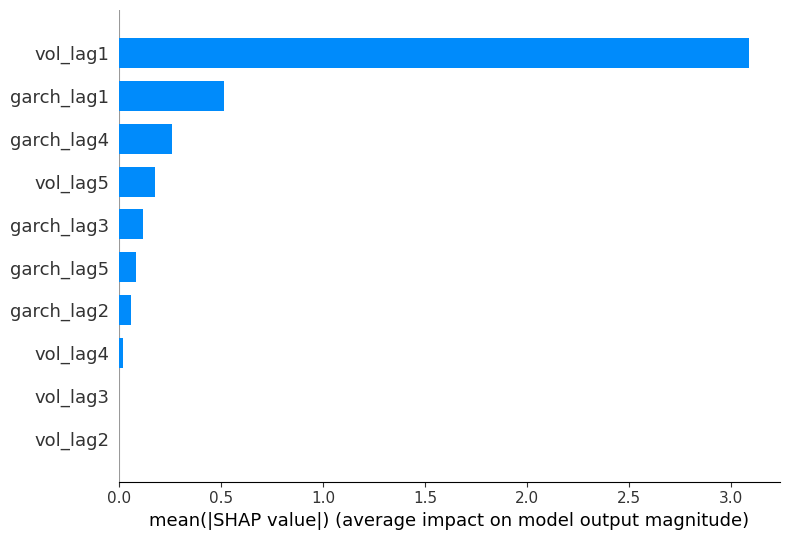

In [ ]:
# SHAP Analysis for Decision Tree Regressor

# Select the final window of data to analyze feature importance
final_tree_df = df_tree.iloc[-500:]  # Use the last 500 observations
X_tree = final_tree_df.drop(columns='y')
y_tree = final_tree_df['y']

# Train a Decision Tree Regressor on the selected data
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_tree, y_tree)

# Use SHAP's TreeExplainer to compute SHAP values
explainer_tree = shap.TreeExplainer(tree_model)
shap_values_tree = explainer_tree.shap_values(X_tree)

# Generate a summary bar plot of SHAP values for feature importance
shap.summary_plot(shap_values_tree, X_tree, plot_type="bar", show=True)

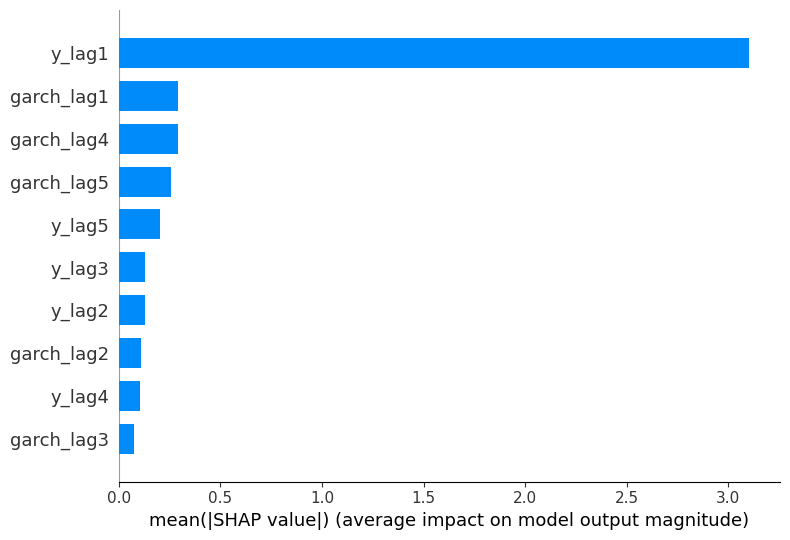

In [ ]:
# SHAP Analysis for Hybrid Model (Random Forest + GARCH Features)

# Select the final window of hybrid features for analysis
final_hybrid_df = df_hybrid.iloc[-500:]
X_hybrid = final_hybrid_df.drop(columns='y')
y_hybrid = final_hybrid_df['y']

# Train the Random Forest model on hybrid features
rf_hybrid_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hybrid_model.fit(X_hybrid, y_hybrid)

# Use SHAP TreeExplainer to interpret feature importance
explainer_hybrid = shap.TreeExplainer(rf_hybrid_model)
shap_values_hybrid = explainer_hybrid.shap_values(X_hybrid)

# Visualize the SHAP feature importance (global)
shap.summary_plot(shap_values_hybrid, X_hybrid, plot_type="bar", show=True)

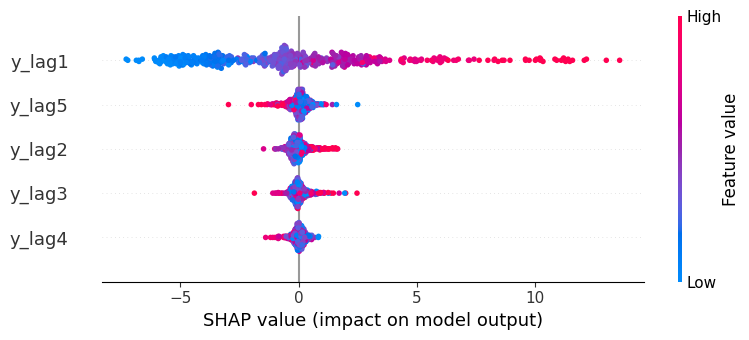

In [ ]:
#SHAP Summary Plot
shap.summary_plot(shap_values_rf, X_rf)  # or X_tree, X_hybrid

____

# **<center>Forecasting Model Performance Summary (S&P 500 Volatility) – Ranked by RMSE</center>**

The table below presents a ranked comparison of all volatility forecasting models evaluated in this study. Ranking is based on RMSE, a standard metric for measuring the magnitude of forecast error. The top-performing models — particularly the Deep Neural Network (DNN) and the HAR model — demonstrate significantly better accuracy compared to traditional statistical models like GARCH(1,1).

| Rank | Model             | RMSE  | MAE   | MAPE   |
|------|-------------------|-------|-------|--------|
| 1    | Deep Neural Net   | 3.71  | 2.61  | 22.98% |
| 2    | HAR               | 3.86  | 2.57  | 21.48% |
| 3    | Hybrid (RF+GARCH) | 3.84  | 2.67  | 22.54% |
| 4    | Decision Tree     | 4.33  | 2.96  | 24.76% |
| 5    | Hybrid LSTM       | 4.88  | 3.60  | 35.58% |
| 6    | Random Forest     | 4.95  | 2.96  | 25.55% |
| 7    | GARCH(1,1)        | 9.25  | 6.16  | 91.05% |



### Formula for RMSE

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \hat{y}_i - y_i \right)^2 }
$$

Where:
- $\hat{y}_i$ = predicted value  
-  $y_i$ = actual (true) value  
-  $n$ = number of observations



### Why RMSE?

- RMSE is expressed in the **same units** as the target variable — in this case, volatility (%).
- It **penalizes large errors more heavily** than metrics like MAE, making it particularly relevant in financial contexts where large deviations are costly.
- A **lower RMSE** indicates greater predictive accuracy and model reliability.


### Interpretation in This Study

In the context of forecasting realized volatility for the S&P 500, RMSE provides a consistent basis to compare the magnitude of forecast errors across a wide variety of models — from traditional statistical frameworks (like GARCH) to machine learning models (Random Forests, Neural Networks), and hybrid combinations. As shown in the table, models that incorporate nonlinear learning (DNN, Hybrid RF+GARCH) or multi-frequency structure (HAR) consistently outperform more rigid models, highlighting the value of both flexibility and domain-informed features.



### Next Step: Building a New Hybrid Model

Given the strong individual performance of both the HAR model and the Deep Neural Network (DNN), we proceed by combining their strengths into a new hybrid model. This hybrid architecture uses HAR-based lag features (daily, weekly, monthly realized volatility) as inputs to a DNN, allowing the model to retain structured volatility dynamics while capturing additional nonlinear relationships.

The goal is to explore whether this integration can yield further improvements in forecasting accuracy beyond what either model achieves independently.

_____

## **<center>Using HAR and Deep Neural Network to Create a Hybrid Model for Forecasting Volatility</center>**

From the model comparison table above, it is clear that the Heterogeneous Autoregressive (HAR) model and the Deep Neural Network (DNN) are the top-performing approaches in terms of volatility forecast accuracy. Each model brings a distinct advantage: the HAR model offers structural interpretability and effectively captures volatility persistence across daily, weekly, and monthly horizons; meanwhile, DNNs are highly capable of modeling complex nonlinear patterns that traditional econometric frameworks typically miss.

To harness the strengths of both, we develop a **hybrid model** that integrates HAR-based features directly into a deep neural network. This architecture retains the intuitive multi-frequency structure of the HAR model while enabling the network to learn richer and more flexible nonlinear relationships within the input data.

The objective is to **enhance predictive performance by combining domain-informed structure with data-driven flexibility** — a synthesis of statistical robustness and machine learning expressiveness. This hybrid approach serves as a promising direction for building volatility forecasting tools that are both accurate and interpretable in real-world financial applications.

In [ ]:
# Create HAR-style lagged features for use in a DNN

def create_har_dnn_features(rv_series):
    """
    Generates HAR (Heterogeneous Autoregressive) features for volatility forecasting
    using a Deep Neural Network. It includes daily, weekly, and monthly average volatility lags.

    Parameters:
    -----------
    rv_series : pd.Series
        Time series of realized volatility (target variable), assumed to be daily and annualized.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame containing:
        - Target variable 'y' (current realized volatility)
        - 'rv_d' : 1-day lag of realized volatility
        - 'rv_w' : 5-day (1 week) average of realized volatility, lagged by 1 day
        - 'rv_m' : 22-day (1 month) average of realized volatility, lagged by 1 day
    """
    df = pd.DataFrame({'y': rv_series})

    # Daily lag (yesterday's realized volatility)
    df['rv_d'] = df['y'].shift(1)

    # Weekly lag (average of past 5 days, shifted 1 day to prevent lookahead bias)
    df['rv_w'] = df['y'].rolling(window=5).mean().shift(1)

    # Monthly lag (average of past 22 trading days, shifted 1 day)
    df['rv_m'] = df['y'].rolling(window=22).mean().shift(1)

    # Drop rows with NaNs introduced by shifting and rolling
    return df.dropna()

In [ ]:
# Build and Train the DNN model on HAR Features 

# Prepare features
df_hybrid = create_har_dnn_features(realized_vol)
X = df_hybrid.drop(columns='y').values
y = df_hybrid['y'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build DNN
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile and train
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 422.9959 
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 396.7034
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 250.7142
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 125.4120
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 63.4097
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 60.3592
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 42.5925
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 34.6860
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 33.5392
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 30.8865
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 28.7808
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 28.8428
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 32.2687
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 26.5771
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/s

In [ ]:
# Generate predictions from the trained DNN model
y_pred = model.predict(X_test_scaled).flatten()  # Flatten to match y_test shape

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))     
mae = mean_absolute_error(y_test, y_pred)              
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  

# Display results
print(f"HAR + DNN RMSE: {rmse:.2f}")
print(f"HAR + DNN MAE: {mae:.2f}")
print(f"HAR + DNN MAPE: {mape:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
HAR + DNN RMSE: 3.37
HAR + DNN MAE: 2.16
HAR + DNN MAPE: 21.89%


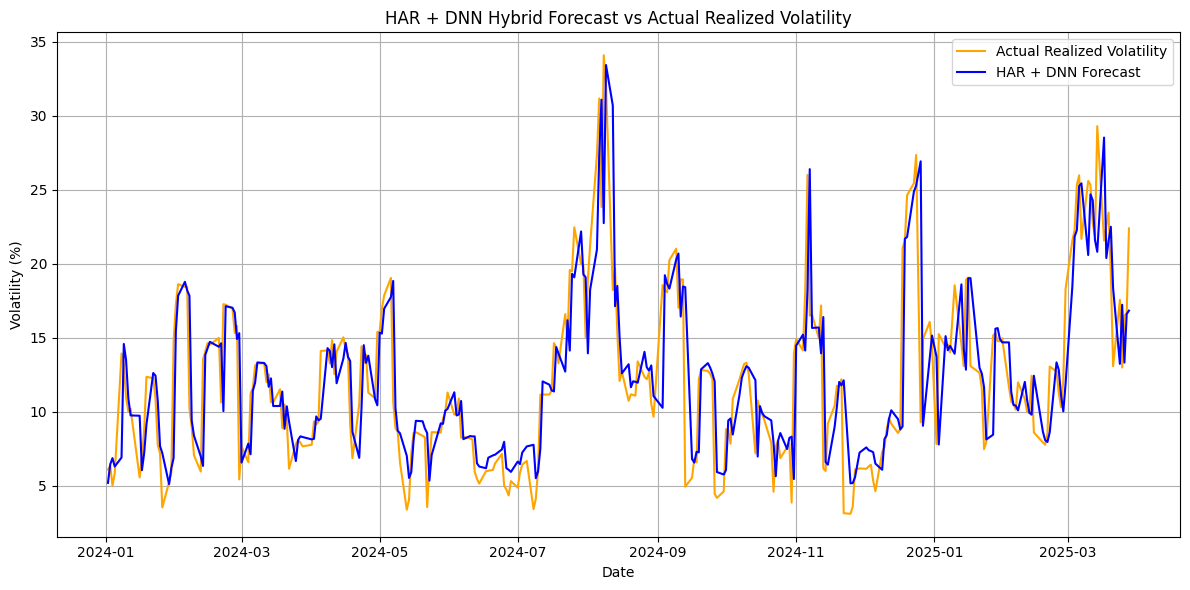

In [74]:
# Plot the hybrid forecast vs actual realized volatility

plt.figure(figsize=(12, 6))
plt.plot(df_hybrid.index[-len(y_test):], y_test, label='Actual Realized Volatility', color='orange')
plt.plot(df_hybrid.index[-len(y_test):], y_pred, label='HAR + DNN Forecast', color='blue')
plt.title('HAR + DNN Hybrid Forecast vs Actual Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Final Model Performance Summary (S&P 500 Volatility) – Ranked by RMSE**

| Rank | Model               | RMSE  | MAE   | MAPE    |
|------|---------------------|-------|-------|---------|
| 1    | HAR + DNN Hybrid    | **3.37**  | **2.16**  | **21.89%** |
| 2    | Deep Neural Net     | 3.71  | 2.61  | 22.98%  |
| 3    | Hybrid (RF + GARCH) | 3.84  | 2.67  | 22.54%  |
| 4    | HAR                 | 3.86  | 2.57  | 21.48%  |
| 5    | Decision Tree       | 4.33  | 2.96  | 24.76%  |
| 6    | Hybrid LSTM         | 4.88  | 3.60  | 35.58%  |
| 7    | Random Forest       | 4.95  | 2.96  | 25.55%  |
| 8    | GARCH(1,1)          | 9.25  | 6.16  | 91.05%  |

---

## **HAR + DNN Hybrid: Best-in-Class Volatility Forecasting**

By combining the structured, multi-horizon volatility dynamics of the **HAR model** with the nonlinear function approximation of a **Deep Neural Network**, the **HAR + DNN hybrid** emerges as the best-performing model in this study.

Key results:

- It achieved the **lowest RMSE (3.37)**, indicating the smallest forecast error on average.
- It also delivered the **lowest MAE (2.16)**, highlighting its consistency in error magnitude.
- Its **MAPE (21.89%)** was among the best, only marginally higher than the HAR model, yet outperforming all standalone ML approaches.

This hybrid structure offers the best of both worlds:
- **Structural interpretability** via HAR lags (daily, weekly, monthly),
- **Nonlinear modeling power** via deep learning,
- **Generalizability** through data-driven learning on structured features.

### Conclusion

The success of the HAR + DNN hybrid model underscores the value of **hybrid architectures** in financial forecasting — especially those that blend domain knowledge (HAR) with machine learning's capacity for capturing hidden patterns.

Its performance, scalability, and interpretability make it an excellent candidate for real-world deployment in volatility forecasting, trading signal calibration, or risk management pipelines.